In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

Summary spreadsheet at https://docs.google.com/spreadsheets/d/1AYr4MBbA2CfVrwCyadqdoyQdSvFyMFH6nwrLvn63aB0/edit?usp=sharing

# Prepare data

Dataset from https://archive.ics.uci.edu/ml/datasets/banknote+authentication

In [6]:
data = pd.read_csv('../../data/banknote_authentication.txt', header=None)
data_shuffled = data.values
np.random.shuffle(data_shuffled)
data = pd.DataFrame(data_shuffled, index=data.index, columns=data.columns)

In [63]:
data.describe()

,0,1,2,3,4
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


In [64]:
x, t = data.loc[:,0:3], data.loc[:,4]

In [65]:
t.value_counts()

0.0    762
1.0    610
Name: 4, dtype: int64

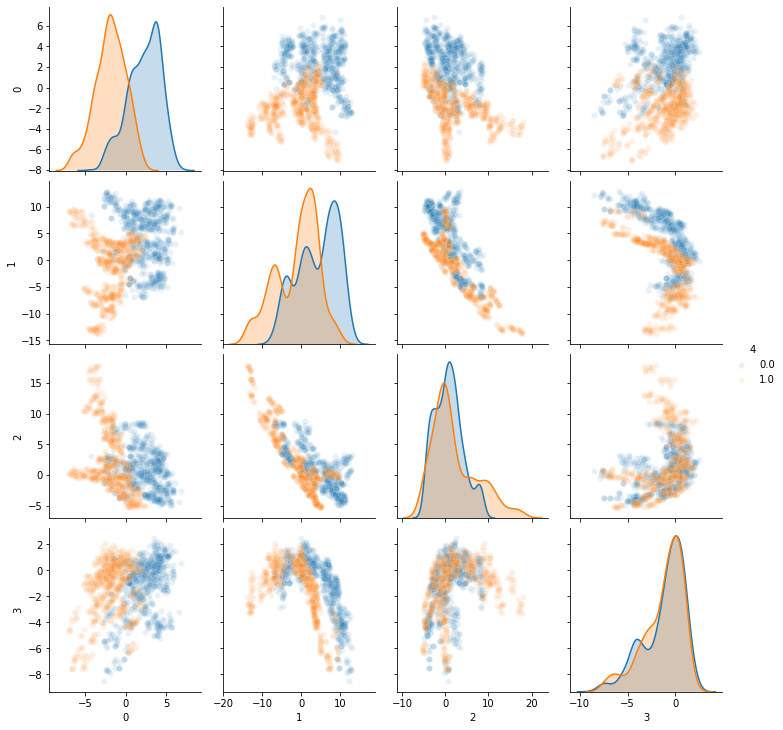

In [66]:
sns.pairplot(data, hue=4, plot_kws={'alpha': 0.1})

### Train/test split

Use an initial 80/20 train/test split, then proceed to 5-fold CV. 

In [67]:
x_train, x_test, t_train, t_test = train_test_split(x, t, test_size=0.2, random_state=42, stratify=t)

In [68]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

In [69]:
t_train, t_test = t_train.values, t_test.values

#### Note on train/test split vs. cross-validation
Going from a train-test split to cross-validation seems arbitrary to me, so I'll go with both throughout (train-test split to show learning or lackthereof within a training run) instead for hyperparameter selection.

###  Dummy class ("one-hot") encoding
Appears to be unnecessary: see e.g. https://www.tensorflow.org/tutorials/keras/classification.

# Keras sequential model for classification

Implement a classifier with 2 dense hidden layers and a dropout layer before the final softmax output layer, something like this:  
Input -> Hidden -> Hidden -> Dropout -> Softmax

Start with a dropout ratio of 0.25, Adadelta as optimizer, and 10 epochs of training.

**Note:** I run most of the following multiple times (more than reflected in spreadsheet), so the associated remarks aren't based on what may just be flukes.

## Model builder

In [118]:
def get_model(layer_sizes, activations, loss, optimizer, metrics, dropout=None, input_dropout=None):
    model = keras.Sequential()
    n_layers = len(layer_sizes)
    if dropout is None:
        dropout = [None] * n_layers
    if input_dropout:
        model.add(layers.Dropout(input_dropout))
    for i in range(n_layers):
        model.add(layers.Dense(layer_sizes[i], activation=activations[i]))
        if dropout[i]:
            model.add(layers.Dropout(dropout[i]))
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

**Note:** 
1. Calling this from per-model "constructors" instead of directly because the workaround for an error-free workflow with its args passed to KerasClassifier() is ugly.
2. Also, I didn't check very carefully, but there seems to be no way to access the model model constructed and wrapped by KerasClassifier(), so the models (NNs) used for train/test and CV are distinct.

## Without dropout

In [71]:
def baseline_model():
    return get_model([10, 10, 1], ['sigmoid'] * 3, 'binary_crossentropy', 'Adadelta', ['accuracy'])

In [73]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=20, batch_size=64, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, x.values, t.values, cv=kfold)
print(results)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

[0.44363636 0.47636363 0.44525549 0.55474454 0.53284669]
Accuracy: 49.06% (4.55%)


In [74]:
model = baseline_model()
model.fit(x_train, t_train, validation_data=(x_test, t_test), epochs=20, batch_size=64)

Train on 1097 samples, validate on 275 samples
Epoch 1/20
1097/1097 [==============================] - 3s 3ms/sample - loss: 0.7125 - accuracy: 0.4448 - val_loss: 0.7127 - val_accuracy: 0.4436
Epoch 2/20
1097/1097 [==============================] - 0s 305us/sample - loss: 0.7125 - accuracy: 0.4448 - val_loss: 0.7127 - val_accuracy: 0.4436
Epoch 3/20
1097/1097 [==============================] - 0s 273us/sample - loss: 0.7125 - accuracy: 0.4448 - val_loss: 0.7127 - val_accuracy: 0.4436
Epoch 4/20
1097/1097 [==============================] - 0s 260us/sample - loss: 0.7125 - accuracy: 0.4448 - val_loss: 0.7127 - val_accuracy: 0.4436
Epoch 5/20
1097/1097 [==============================] - 0s 284us/sample - loss: 0.7124 - accuracy: 0.4448 - val_loss: 0.7126 - val_accuracy: 0.4436
Epoch 6/20
1097/1097 [==============================] - 0s 205us/sample - loss: 0.7124 - accuracy: 0.4448 - val_loss: 0.7126 - val_accuracy: 0.4436
Epoch 7/20
1097/1097 [==============================] - 1s 481us/sa

**Remarks:** Train/test and CV results are similar. They stink. Not only is accuracy low, it doesn't even improve from the first epoch to the last.

## With dropout

### In 2nd hidden layer: dropout ratio 0.25

In [75]:
def basic_dropout_model():
    return get_model([10, 10, 1], ['sigmoid'] * 3, 'binary_crossentropy', 'Adadelta', ['accuracy'],
                     dropout=[0, 0.25, 0])

In [76]:
estimator = KerasClassifier(build_fn=basic_dropout_model, epochs=20, batch_size=64, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, x.values, t.values, cv=kfold)
print(results)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

[0.55636364 0.32363635 0.44525549 0.55474454 0.44525549]
Accuracy: 46.51% (8.62%)


In [77]:
model = basic_dropout_model()
model.fit(x_train, t_train, validation_data=(x_test, t_test), epochs=20, batch_size=64)

Train on 1097 samples, validate on 275 samples
Epoch 1/20
1097/1097 [==============================] - 3s 3ms/sample - loss: 0.7172 - accuracy: 0.4840 - val_loss: 0.7029 - val_accuracy: 0.4436
Epoch 2/20
1097/1097 [==============================] - 0s 260us/sample - loss: 0.7156 - accuracy: 0.4859 - val_loss: 0.7029 - val_accuracy: 0.4436
Epoch 3/20
1097/1097 [==============================] - 0s 235us/sample - loss: 0.7175 - accuracy: 0.4822 - val_loss: 0.7028 - val_accuracy: 0.4436
Epoch 4/20
1097/1097 [==============================] - 0s 265us/sample - loss: 0.7251 - accuracy: 0.4722 - val_loss: 0.7028 - val_accuracy: 0.4436
Epoch 5/20
1097/1097 [==============================] - 0s 232us/sample - loss: 0.7165 - accuracy: 0.4913 - val_loss: 0.7028 - val_accuracy: 0.4436
Epoch 6/20
1097/1097 [==============================] - 0s 301us/sample - loss: 0.7177 - accuracy: 0.4986 - val_loss: 0.7028 - val_accuracy: 0.4436
Epoch 7/20
1097/1097 [==============================] - 0s 215us/sa

**Remarks:** The results are better, but they're still not good.

### In 2nd hidden layer: dropout ratio 0.4

In [78]:
def basic_dropout_model_pt4():
    return get_model([10, 10, 1], ['sigmoid'] * 3, 'binary_crossentropy', 'Adadelta', ['accuracy'],
                     dropout=[0, 0.4, 0])

In [80]:
estimator = KerasClassifier(build_fn=basic_dropout_model_pt4, epochs=20, batch_size=64, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, x.values, t.values, cv=kfold)
print(results)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

[0.44363636 0.44363636 0.55474454 0.55474454 0.5109489 ]
Accuracy: 50.15% (4.99%)


In [81]:
model = basic_dropout_model_pt4()
model.fit(x_train, t_train, validation_data=(x_test, t_test), epochs=20, batch_size=64)

Train on 1097 samples, validate on 275 samples
Epoch 1/20
1097/1097 [==============================] - 4s 3ms/sample - loss: 0.7275 - accuracy: 0.5169 - val_loss: 0.6995 - val_accuracy: 0.5200
Epoch 2/20
1097/1097 [==============================] - 0s 220us/sample - loss: 0.7345 - accuracy: 0.4986 - val_loss: 0.6995 - val_accuracy: 0.5200
Epoch 3/20
1097/1097 [==============================] - 0s 242us/sample - loss: 0.7397 - accuracy: 0.4877 - val_loss: 0.6995 - val_accuracy: 0.5200
Epoch 4/20
1097/1097 [==============================] - 0s 233us/sample - loss: 0.7076 - accuracy: 0.5378 - val_loss: 0.6995 - val_accuracy: 0.5200
Epoch 5/20
1097/1097 [==============================] - 0s 262us/sample - loss: 0.7346 - accuracy: 0.4877 - val_loss: 0.6995 - val_accuracy: 0.5200
Epoch 6/20
1097/1097 [==============================] - 0s 324us/sample - loss: 0.7287 - accuracy: 0.4959 - val_loss: 0.6995 - val_accuracy: 0.5200
Epoch 7/20
1097/1097 [==============================] - 0s 309us/sa

**Remarks:** The range of results here seem similarly wide to those from the architecture with dropout ratio 0.25 in the 2nd (last) hidden layer, so it's not clear if they're substantively different.

### Dropout ratio 0.2 for both hidden layers

In [82]:
def all_dropout_model():
    return get_model([10, 10, 1], ['sigmoid'] * 3, 'binary_crossentropy', 'Adadelta', ['accuracy'],
                     dropout=[0.2, 0.2, 0])

In [458]:
estimator = KerasClassifier(build_fn=all_dropout_model, epochs=20, batch_size=64, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, x.values, t.values, cv=kfold)
print(results)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

[0.44363636 0.28363636 0.60583943 0.37956205 0.45985401]
Accuracy: 43.45% (10.57%)


In [459]:
model = all_dropout_model()
model.fit(x_train, t_train, validation_data=(x_test, t_test), epochs=20, batch_size=64)

Train on 1097 samples, validate on 275 samples
Epoch 1/10
1097/1097 [==============================] - 12s 11ms/sample - loss: 0.8541 - accuracy: 0.4458 - val_loss: 0.8543 - val_accuracy: 0.4436
Epoch 2/10
1097/1097 [==============================] - 0s 179us/sample - loss: 0.8597 - accuracy: 0.4467 - val_loss: 0.8542 - val_accuracy: 0.4436
Epoch 3/10
1097/1097 [==============================] - 0s 183us/sample - loss: 0.8580 - accuracy: 0.4448 - val_loss: 0.8540 - val_accuracy: 0.4436
Epoch 4/10
1097/1097 [==============================] - 0s 186us/sample - loss: 0.8604 - accuracy: 0.4467 - val_loss: 0.8539 - val_accuracy: 0.4436
Epoch 5/10
1097/1097 [==============================] - 0s 178us/sample - loss: 0.8645 - accuracy: 0.4448 - val_loss: 0.8537 - val_accuracy: 0.4436
Epoch 6/10
1097/1097 [==============================] - 0s 207us/sample - loss: 0.8517 - accuracy: 0.4458 - val_loss: 0.8536 - val_accuracy: 0.4436
Epoch 7/10
1097/1097 [==============================] - 0s 172us/

**Remarks:** The results again seem to vary widely, and it's unclear whether this architecture is substantively different.

## Using relu instead of sigmoid activation in hidden layers

In [83]:
def basic_relu_model():
    return get_model([10, 10, 1], ['relu', 'relu', 'sigmoid'], 'binary_crossentropy', 'Adadelta', ['accuracy'],
                     dropout=[0, 0.25, 0])

In [461]:
estimator = KerasClassifier(build_fn=basic_relu_model, epochs=20, batch_size=64, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, x.values, t.values, cv=kfold)
print(results)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

[0.43636364 0.22909091 0.56569344 0.50729924 0.67518246]
Accuracy: 48.27% (14.90%)


In [462]:
model = basic_relu_model()
model.fit(x_train, t_train, validation_data=(x_test, t_test), epochs=20, batch_size=64)

Train on 1097 samples, validate on 275 samples
Epoch 1/10
1097/1097 [==============================] - 2s 2ms/sample - loss: 0.6906 - accuracy: 0.5278 - val_loss: 0.6949 - val_accuracy: 0.5491
Epoch 2/10
1097/1097 [==============================] - 0s 195us/sample - loss: 0.6937 - accuracy: 0.5232 - val_loss: 0.6947 - val_accuracy: 0.5491
Epoch 3/10
1097/1097 [==============================] - 0s 210us/sample - loss: 0.6946 - accuracy: 0.5287 - val_loss: 0.6945 - val_accuracy: 0.5491
Epoch 4/10
1097/1097 [==============================] - 0s 203us/sample - loss: 0.6969 - accuracy: 0.5251 - val_loss: 0.6944 - val_accuracy: 0.5491
Epoch 5/10
1097/1097 [==============================] - 0s 182us/sample - loss: 0.6986 - accuracy: 0.5160 - val_loss: 0.6942 - val_accuracy: 0.5491
Epoch 6/10
1097/1097 [==============================] - 0s 314us/sample - loss: 0.6942 - accuracy: 0.5141 - val_loss: 0.6940 - val_accuracy: 0.5527
Epoch 7/10
1097/1097 [==============================] - 0s 247us/sa

**Remarks:** The results are substantially better than with 2 sigmoid-activation hidden layers.

## Varying network depth & width (hidden layer numbers & sizes)

### Using sigmoid activations

In [84]:
def bigger_sigmoid_model():
    return get_model([40, 20, 1], ['sigmoid'] * 3, 'binary_crossentropy', 'Adadelta', ['accuracy'],
                     dropout=[0, 0.25, 0])

In [539]:
estimator = KerasClassifier(build_fn=bigger_sigmoid_model, epochs=20, batch_size=64, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, x.values, t.values, cv=kfold)
print(results)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

[0.44363636 0.44363636 0.44525549 0.55474454 0.55474454]
Accuracy: 48.84% (5.42%)


In [540]:
model = bigger_sigmoid_model()
model.fit(x_train, t_train, validation_data=(x_test, t_test), epochs=20, batch_size=64)

Train on 1097 samples, validate on 275 samples
Epoch 1/10
1097/1097 [==============================] - 2s 2ms/sample - loss: 0.7107 - accuracy: 0.5269 - val_loss: 0.6934 - val_accuracy: 0.5564
Epoch 2/10
1097/1097 [==============================] - 0s 184us/sample - loss: 0.7072 - accuracy: 0.5542 - val_loss: 0.6933 - val_accuracy: 0.5564
Epoch 3/10
1097/1097 [==============================] - 0s 199us/sample - loss: 0.7208 - accuracy: 0.5314 - val_loss: 0.6932 - val_accuracy: 0.5564
Epoch 4/10
1097/1097 [==============================] - 0s 230us/sample - loss: 0.7095 - accuracy: 0.5479 - val_loss: 0.6932 - val_accuracy: 0.5564
Epoch 5/10
1097/1097 [==============================] - 0s 203us/sample - loss: 0.7076 - accuracy: 0.5324 - val_loss: 0.6931 - val_accuracy: 0.5564
Epoch 6/10
1097/1097 [==============================] - 0s 187us/sample - loss: 0.7001 - accuracy: 0.5415 - val_loss: 0.6930 - val_accuracy: 0.5564
Epoch 7/10
1097/1097 [==============================] - 0s 183us/sa

**Remarks:** Still not substantially better than the same model with 10 units per hidden layer. Also tried (60, 20), but the gains seem small relative to the increase in model complexity.

### Using ReLu activations

In [85]:
def bigger_relu_model():
    return get_model([40, 20, 1], ['relu', 'relu', 'sigmoid'], 'binary_crossentropy', 'Adadelta', ['accuracy'],
                     dropout=[0, 0.25, 0])

In [543]:
estimator = KerasClassifier(build_fn=bigger_relu_model, epochs=20, batch_size=64, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, x.values, t.values, cv=kfold)
print(results)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

[0.38545454 0.46909091 0.66423357 0.69343066 0.55474454]
Accuracy: 55.34% (11.59%)


In [544]:
model = bigger_relu_model()
model.fit(x_train, t_train, validation_data=(x_test, t_test), epochs=20, batch_size=64)

Train on 1097 samples, validate on 275 samples
Epoch 1/10
1097/1097 [==============================] - 2s 1ms/sample - loss: 0.6929 - accuracy: 0.5552 - val_loss: 0.6860 - val_accuracy: 0.5564
Epoch 2/10
1097/1097 [==============================] - 0s 228us/sample - loss: 0.6972 - accuracy: 0.5469 - val_loss: 0.6856 - val_accuracy: 0.5564
Epoch 3/10
1097/1097 [==============================] - 0s 187us/sample - loss: 0.6986 - accuracy: 0.5506 - val_loss: 0.6853 - val_accuracy: 0.5564
Epoch 4/10
1097/1097 [==============================] - 0s 187us/sample - loss: 0.6952 - accuracy: 0.5561 - val_loss: 0.6850 - val_accuracy: 0.5564
Epoch 5/10
1097/1097 [==============================] - 0s 190us/sample - loss: 0.6978 - accuracy: 0.5606 - val_loss: 0.6847 - val_accuracy: 0.5564
Epoch 6/10
1097/1097 [==============================] - 0s 184us/sample - loss: 0.6984 - accuracy: 0.5506 - val_loss: 0.6844 - val_accuracy: 0.5564
Epoch 7/10
1097/1097 [==============================] - 0s 232us/sa

In [545]:
def medium_relu_model():
    return get_model([20, 20, 1], ['relu', 'relu', 'sigmoid'], 'binary_crossentropy', 'Adadelta', ['accuracy'],
                     dropout=[0, 0.25, 0])

In [546]:
estimator = KerasClassifier(build_fn=medium_relu_model, epochs=20, batch_size=64, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, x.values, t.values, cv=kfold)
print(results)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

[0.43636364 0.42909092 0.41240877 0.60948902 0.59489053]
Accuracy: 49.64% (8.68%)


In [547]:
model = medium_relu_model()
model.fit(x_train, t_train, validation_data=(x_test, t_test), epochs=20, batch_size=64)

Train on 1097 samples, validate on 275 samples
Epoch 1/10
1097/1097 [==============================] - 2s 1ms/sample - loss: 0.6775 - accuracy: 0.5880 - val_loss: 0.6916 - val_accuracy: 0.5600
Epoch 2/10
1097/1097 [==============================] - 0s 183us/sample - loss: 0.6813 - accuracy: 0.5798 - val_loss: 0.6914 - val_accuracy: 0.5600
Epoch 3/10
1097/1097 [==============================] - 0s 182us/sample - loss: 0.6774 - accuracy: 0.5834 - val_loss: 0.6912 - val_accuracy: 0.5600
Epoch 4/10
1097/1097 [==============================] - 0s 380us/sample - loss: 0.6817 - accuracy: 0.5962 - val_loss: 0.6910 - val_accuracy: 0.5600
Epoch 5/10
1097/1097 [==============================] - 0s 281us/sample - loss: 0.6805 - accuracy: 0.5670 - val_loss: 0.6909 - val_accuracy: 0.5600
Epoch 6/10
1097/1097 [==============================] - 0s 224us/sample - loss: 0.6738 - accuracy: 0.5962 - val_loss: 0.6907 - val_accuracy: 0.5636
Epoch 7/10
1097/1097 [==============================] - 0s 276us/sa

**Remarks:** ReLu seems to vary dramatically in performance on this dataset. Over several runs (many omitted from the spreadsheet for consistency, and including more basic (10, 10) ReLu network runs), it shows both the highest and lowest accuracies seen so far. In fact, the limited training rounds I've run may suggest its performance is declining with increasing hidden layer units, which could be an indication of overfitting.

### Using both sigmoid and ReLu activations

In [490]:
def relu_sigmoid_model():
    return get_model([10, 20, 1], ['relu', 'sigmoid', 'sigmoid'], 'binary_crossentropy', 'Adadelta', ['accuracy'],
                     dropout=[0, 0.25, 0])

In [497]:
estimator = KerasClassifier(build_fn=relu_sigmoid_model, epochs=20, batch_size=64, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, x.values, t.values, cv=kfold)
print(results)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

[0.55636364 0.44363636 0.55474454 0.53649634 0.47080293]
Accuracy: 51.24% (4.64%)


In [498]:
model = relu_sigmoid_model()
model.fit(x_train, t_train, validation_data=(x_test, t_test), epochs=20, batch_size=64)

Train on 1097 samples, validate on 275 samples
Epoch 1/10
1097/1097 [==============================] - 1s 1ms/sample - loss: 0.7509 - accuracy: 0.4540 - val_loss: 0.7154 - val_accuracy: 0.4073
Epoch 2/10
1097/1097 [==============================] - 0s 181us/sample - loss: 0.7490 - accuracy: 0.4439 - val_loss: 0.7153 - val_accuracy: 0.4073
Epoch 3/10
1097/1097 [==============================] - 0s 177us/sample - loss: 0.7306 - accuracy: 0.5005 - val_loss: 0.7152 - val_accuracy: 0.4073
Epoch 4/10
1097/1097 [==============================] - 0s 209us/sample - loss: 0.7433 - accuracy: 0.4768 - val_loss: 0.7152 - val_accuracy: 0.4073
Epoch 5/10
1097/1097 [==============================] - 0s 231us/sample - loss: 0.7354 - accuracy: 0.4603 - val_loss: 0.7151 - val_accuracy: 0.4073
Epoch 6/10
1097/1097 [==============================] - 0s 208us/sample - loss: 0.7392 - accuracy: 0.4795 - val_loss: 0.7150 - val_accuracy: 0.4073
Epoch 7/10
1097/1097 [==============================] - 0s 182us/sa

**Remarks:** This seems to be one of the most consistent of the networks tried, but again that's not obvious, and may be due to chance.

### Deeper sigmoid network

#### Note: Results when spreadsheet was first created invalidated (though they shouldn't be much different) due to bug in get_model(). They have been struck out because with hindsight, this is obviously not the right model, and I don't want to redo the work just for the record

In [87]:
def deeper_sigmoid_model():
    return get_model([10, 10, 10, 1], ['sigmoid'] * 4, 'binary_crossentropy', 'Adadelta', ['accuracy'],
                     dropout=[0.25, 0.25, 0.25, 0])

In [88]:
estimator = KerasClassifier(build_fn=deeper_sigmoid_model, epochs=20, batch_size=64, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, x.values, t.values, cv=kfold)
print(results)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

[0.44363636 0.44363636 0.44525549 0.55474454 0.44525549]
Accuracy: 46.65% (4.41%)


In [89]:
model = deeper_sigmoid_model()
model.fit(x_train, t_train, validation_data=(x_test, t_test), epochs=20, batch_size=64)

Train on 1097 samples, validate on 275 samples
Epoch 1/20
1097/1097 [==============================] - 3s 3ms/sample - loss: 0.8378 - accuracy: 0.4458 - val_loss: 0.8335 - val_accuracy: 0.4436
Epoch 2/20
1097/1097 [==============================] - 0s 260us/sample - loss: 0.8400 - accuracy: 0.4439 - val_loss: 0.8335 - val_accuracy: 0.4436
Epoch 3/20
1097/1097 [==============================] - 0s 267us/sample - loss: 0.8672 - accuracy: 0.4412 - val_loss: 0.8334 - val_accuracy: 0.4436
Epoch 4/20
1097/1097 [==============================] - 0s 279us/sample - loss: 0.8468 - accuracy: 0.4467 - val_loss: 0.8333 - val_accuracy: 0.4436
Epoch 5/20
1097/1097 [==============================] - 0s 261us/sample - loss: 0.8335 - accuracy: 0.4430 - val_loss: 0.8332 - val_accuracy: 0.4436
Epoch 6/20
1097/1097 [==============================] - 0s 315us/sample - loss: 0.8383 - accuracy: 0.4485 - val_loss: 0.8332 - val_accuracy: 0.4436
Epoch 7/20
1097/1097 [==============================] - 0s 303us/sa

### Deeper ReLu network

In [90]:
def deeper_relu_model():
    return get_model([10, 10, 10, 1], ['relu'] * 3 + ['sigmoid'], 'binary_crossentropy', 'Adadelta', ['accuracy'],
                     dropout=[0.25, 0.25, 0.25, 0])

In [100]:
estimator = KerasClassifier(build_fn=deeper_relu_model, epochs=20, batch_size=64, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, x.values, t.values, cv=kfold)
print(results)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

[0.67636365 0.51272726 0.54744524 0.35036495 0.44525549]
Accuracy: 50.64% (10.83%)


In [101]:
model = deeper_relu_model()
model.fit(x_train, t_train, validation_data=(x_test, t_test), epochs=20, batch_size=64)

Train on 1097 samples, validate on 275 samples
Epoch 1/20
1097/1097 [==============================] - 3s 2ms/sample - loss: 0.7203 - accuracy: 0.4239 - val_loss: 0.7106 - val_accuracy: 0.4182
Epoch 2/20
1097/1097 [==============================] - 0s 255us/sample - loss: 0.7208 - accuracy: 0.4284 - val_loss: 0.7105 - val_accuracy: 0.4182
Epoch 3/20
1097/1097 [==============================] - 0s 235us/sample - loss: 0.7181 - accuracy: 0.4394 - val_loss: 0.7105 - val_accuracy: 0.4182
Epoch 4/20
1097/1097 [==============================] - 0s 205us/sample - loss: 0.7208 - accuracy: 0.4339 - val_loss: 0.7105 - val_accuracy: 0.4182
Epoch 5/20
1097/1097 [==============================] - 0s 201us/sample - loss: 0.7139 - accuracy: 0.4430 - val_loss: 0.7104 - val_accuracy: 0.4182
Epoch 6/20
1097/1097 [==============================] - 0s 267us/sample - loss: 0.7113 - accuracy: 0.4686 - val_loss: 0.7104 - val_accuracy: 0.4182
Epoch 7/20
1097/1097 [==============================] - 0s 200us/sa

### Remarks on results so far
Overall, using sigmoid activation gives lower accuracies as well as variance, though dropout mitigates variance considerably in the case of ReLu. Going by the last two networks, using ReLu or a combination, along with dropout in most/all pre-output layers, seems to be a good move.

### Deeper ReLu network with dropout ratio 0.2 for input layer

#### Note: Results when spreadsheet was first created also invalidated and struck out because with hindsight, this is obviously not the right model, and I don't want to redo the work just for the record

In [102]:
def input_dropout_relu_model():
    return get_model([10, 10, 10, 1], ['relu'] * 3 + ['sigmoid'], 'binary_crossentropy', 'Adadelta', ['accuracy'],
                     dropout=[0.25, 0.25, 0.25, 0], input_dropout=0.2)

In [103]:
estimator = KerasClassifier(build_fn=input_dropout_relu_model, epochs=20, batch_size=64, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, x.values, t.values, cv=kfold)
print(results)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

[0.37454545 0.16727273 0.55474454 0.54014599 0.47080293]
Accuracy: 42.15% (14.22%)


In [104]:
model = input_dropout_relu_model()
model.fit(x_train, t_train, validation_data=(x_test, t_test), epochs=20, batch_size=64)

Train on 1097 samples, validate on 275 samples
Epoch 1/20
1097/1097 [==============================] - 3s 2ms/sample - loss: 0.8852 - accuracy: 0.5278 - val_loss: 0.8649 - val_accuracy: 0.5564
Epoch 2/20
1097/1097 [==============================] - 0s 177us/sample - loss: 0.8611 - accuracy: 0.5251 - val_loss: 0.8648 - val_accuracy: 0.5564
Epoch 3/20
1097/1097 [==============================] - 0s 226us/sample - loss: 0.8941 - accuracy: 0.5068 - val_loss: 0.8647 - val_accuracy: 0.5564
Epoch 4/20
1097/1097 [==============================] - 0s 222us/sample - loss: 0.8628 - accuracy: 0.5314 - val_loss: 0.8646 - val_accuracy: 0.5564
Epoch 5/20
1097/1097 [==============================] - 0s 236us/sample - loss: 0.8844 - accuracy: 0.5251 - val_loss: 0.8645 - val_accuracy: 0.5564
Epoch 6/20
1097/1097 [==============================] - 0s 203us/sample - loss: 0.8626 - accuracy: 0.5196 - val_loss: 0.8644 - val_accuracy: 0.5564
Epoch 7/20
1097/1097 [==============================] - 0s 219us/sa

**Remarks:** Adding dropout for the input layer while keeping all other hyperparameters the same appears to hurt performance, maybe because the amount of exploitable information decreases overall, in the absence of an increased number of units in the hidden layers.

## Varying all of the above

### Deeper, wider ReLu network with dropout ratio 0.2 for input layer

#### Note: Results at spreadsheet creation also invalidated and struck out. (See another such model above for a bit more detail.)

In [105]:
def relu_model_1():
    return get_model([20, 20, 20, 1], ['relu'] * 3 + ['sigmoid'], 'binary_crossentropy', 'Adadelta', ['accuracy'],
                     dropout=[0.5, 0.5, 0.5, 0], input_dropout=0.2)

In [106]:
estimator = KerasClassifier(build_fn=relu_model_1, epochs=20, batch_size=64, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, x.values, t.values, cv=kfold)
print(results)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

[0.39636365 0.63999999 0.770073   0.26642334 0.47080293]
Accuracy: 50.87% (17.79%)


In [107]:
model = relu_model_1()
model.fit(x_train, t_train, validation_data=(x_test, t_test), epochs=20, batch_size=64)

Train on 1097 samples, validate on 275 samples
Epoch 1/20
1097/1097 [==============================] - 5s 5ms/sample - loss: 0.7603 - accuracy: 0.4850 - val_loss: 0.6872 - val_accuracy: 0.4618
Epoch 2/20
1097/1097 [==============================] - 0s 327us/sample - loss: 0.7643 - accuracy: 0.5032 - val_loss: 0.6872 - val_accuracy: 0.4618
Epoch 3/20
1097/1097 [==============================] - 0s 180us/sample - loss: 0.7626 - accuracy: 0.5087 - val_loss: 0.6871 - val_accuracy: 0.4618
Epoch 4/20
1097/1097 [==============================] - 0s 197us/sample - loss: 0.7510 - accuracy: 0.4932 - val_loss: 0.6871 - val_accuracy: 0.4618
Epoch 5/20
1097/1097 [==============================] - 0s 190us/sample - loss: 0.7700 - accuracy: 0.4950 - val_loss: 0.6871 - val_accuracy: 0.4618
Epoch 6/20
1097/1097 [==============================] - 0s 202us/sample - loss: 0.7503 - accuracy: 0.4950 - val_loss: 0.6870 - val_accuracy: 0.4618
Epoch 7/20
1097/1097 [==============================] - 0s 191us/sa

### "Sandwich" model: 2 ReLus followed by 1 sigmoid-activated hidden layer

#### Note: Earlier results also invalidated and struck out.

In [108]:
def sandwich_model_1():
    return get_model([10, 10, 10, 1], ['relu', 'relu', 'sigmoid', 'sigmoid'], 'binary_crossentropy', 'Adadelta',
                     ['accuracy'], dropout=[0.25, 0.25, 0.25, 0])

In [109]:
estimator = KerasClassifier(build_fn=sandwich_model_1, epochs=20, batch_size=64, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, x.values, t.values, cv=kfold)
print(results)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

[0.70545453 0.43272728 0.44525549 0.55474454 0.55474454]
Accuracy: 53.86% (9.83%)


In [110]:
model = sandwich_model_1()
model.fit(x_train, t_train, validation_data=(x_test, t_test), epochs=20, batch_size=64)

Train on 1097 samples, validate on 275 samples
Epoch 1/20
1097/1097 [==============================] - 2s 2ms/sample - loss: 0.7360 - accuracy: 0.5032 - val_loss: 0.7341 - val_accuracy: 0.4436
Epoch 2/20
1097/1097 [==============================] - 0s 196us/sample - loss: 0.7500 - accuracy: 0.4768 - val_loss: 0.7340 - val_accuracy: 0.4436
Epoch 3/20
1097/1097 [==============================] - 0s 203us/sample - loss: 0.7561 - accuracy: 0.4512 - val_loss: 0.7340 - val_accuracy: 0.4436
Epoch 4/20
1097/1097 [==============================] - 0s 207us/sample - loss: 0.7344 - accuracy: 0.5023 - val_loss: 0.7340 - val_accuracy: 0.4436
Epoch 5/20
1097/1097 [==============================] - 0s 209us/sample - loss: 0.7462 - accuracy: 0.4631 - val_loss: 0.7339 - val_accuracy: 0.4436
Epoch 6/20
1097/1097 [==============================] - 0s 201us/sample - loss: 0.7502 - accuracy: 0.4631 - val_loss: 0.7339 - val_accuracy: 0.4436
Epoch 7/20
1097/1097 [==============================] - 0s 202us/sa

### 4-hidden-layer ReLu network with dropout ratio 0.2 for input layer

#### Note: Earlier results also invalidated and struck out.

In [111]:
def relu_model_4hlayers():
    return get_model([10] * 4 + [1], ['relu'] * 4 + ['sigmoid'], 'binary_crossentropy', 'Adadelta', ['accuracy'],
                     dropout=[0.25] * 4 + [0], input_dropout=0.2)

In [112]:
estimator = KerasClassifier(build_fn=relu_model_4hlayers, epochs=20, batch_size=64, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, x.values, t.values, cv=kfold)
print(results)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

[0.49818182 0.39636365 0.32846716 0.66058391 0.44525549]
Accuracy: 46.58% (11.23%)


In [113]:
model = relu_model_4hlayers()
model.fit(x_train, t_train, validation_data=(x_test, t_test), epochs=20, batch_size=64)

Train on 1097 samples, validate on 275 samples
Epoch 1/20
1097/1097 [==============================] - 8s 7ms/sample - loss: 0.7714 - accuracy: 0.4467 - val_loss: 0.7271 - val_accuracy: 0.4436
Epoch 2/20
1097/1097 [==============================] - 0s 361us/sample - loss: 0.7737 - accuracy: 0.4439 - val_loss: 0.7270 - val_accuracy: 0.4436
Epoch 3/20
1097/1097 [==============================] - 0s 232us/sample - loss: 0.7813 - accuracy: 0.4531 - val_loss: 0.7270 - val_accuracy: 0.4436
Epoch 4/20
1097/1097 [==============================] - 0s 249us/sample - loss: 0.7746 - accuracy: 0.4558 - val_loss: 0.7269 - val_accuracy: 0.4436
Epoch 5/20
1097/1097 [==============================] - 0s 266us/sample - loss: 0.7682 - accuracy: 0.4448 - val_loss: 0.7269 - val_accuracy: 0.4436
Epoch 6/20
1097/1097 [==============================] - 0s 400us/sample - loss: 0.7705 - accuracy: 0.4430 - val_loss: 0.7268 - val_accuracy: 0.4436
Epoch 7/20
1097/1097 [==============================] - 0s 220us/sa

### "Sandwich" model 2: ReLu, sigmoid, ReLu hidden layers

#### Note: Earlier results also invalidated and struck out.

In [115]:
def sandwich_model_2():
    return get_model([20, 20, 20, 1], ['relu', 'sigmoid', 'relu', 'sigmoid'], 'binary_crossentropy', 'Adadelta',
                     ['accuracy'], dropout=[0.25, 0.25, 0.25, 0], input_dropout=0.2)

In [121]:
estimator = KerasClassifier(build_fn=sandwich_model_2, epochs=20, batch_size=64, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, x.values, t.values, cv=kfold)
print(results)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

[0.32727271 0.55636364 0.44525549 0.55474454 0.55474454]
Accuracy: 48.77% (9.08%)


In [122]:
model = sandwich_model_2()
model.fit(x_train, t_train, validation_data=(x_test, t_test), epochs=20, batch_size=64)

Train on 1097 samples, validate on 275 samples
Epoch 1/20
1097/1097 [==============================] - 3s 2ms/sample - loss: 0.7772 - accuracy: 0.4485 - val_loss: 0.7571 - val_accuracy: 0.4436
Epoch 2/20
1097/1097 [==============================] - 0s 225us/sample - loss: 0.7826 - accuracy: 0.4531 - val_loss: 0.7570 - val_accuracy: 0.4436
Epoch 3/20
1097/1097 [==============================] - 0s 254us/sample - loss: 0.7839 - accuracy: 0.4521 - val_loss: 0.7568 - val_accuracy: 0.4436
Epoch 4/20
1097/1097 [==============================] - 0s 231us/sample - loss: 0.7863 - accuracy: 0.4494 - val_loss: 0.7567 - val_accuracy: 0.4436
Epoch 5/20
1097/1097 [==============================] - 0s 225us/sample - loss: 0.7710 - accuracy: 0.4494 - val_loss: 0.7566 - val_accuracy: 0.4436
Epoch 6/20
1097/1097 [==============================] - 0s 226us/sample - loss: 0.7813 - accuracy: 0.4503 - val_loss: 0.7564 - val_accuracy: 0.4436
Epoch 7/20
1097/1097 [==============================] - 0s 212us/sa

### "Sandwich" model 3: 4 alternating ReLu-sigmoid hidden layers

#### Note: Earlier results also invalidated and struck out.

In [129]:
def sandwich_model_3():
    return get_model([20] * 4 + [1], ['relu', 'sigmoid', 'relu', 'relu', 'sigmoid'], 'binary_crossentropy',
                     'Adadelta', ['accuracy'], dropout=[0.25] * 4 + [0], input_dropout=0.2)

In [130]:
estimator = KerasClassifier(build_fn=sandwich_model_3, epochs=20, batch_size=64, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, x.values, t.values, cv=kfold)
print(results)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

[0.55636364 0.40363637 0.25547445 0.44525549 0.53284669]
Accuracy: 43.87% (10.73%)


In [131]:
model = sandwich_model_3()
model.fit(x_train, t_train, validation_data=(x_test, t_test), epochs=20, batch_size=64)

Train on 1097 samples, validate on 275 samples
Epoch 1/20
1097/1097 [==============================] - 4s 4ms/sample - loss: 0.6870 - accuracy: 0.5305 - val_loss: 0.6770 - val_accuracy: 0.5564
Epoch 2/20
1097/1097 [==============================] - 0s 265us/sample - loss: 0.6884 - accuracy: 0.5406 - val_loss: 0.6770 - val_accuracy: 0.5564
Epoch 3/20
1097/1097 [==============================] - 0s 292us/sample - loss: 0.6866 - accuracy: 0.5287 - val_loss: 0.6770 - val_accuracy: 0.5564
Epoch 4/20
1097/1097 [==============================] - 0s 323us/sample - loss: 0.6850 - accuracy: 0.5469 - val_loss: 0.6769 - val_accuracy: 0.5564
Epoch 5/20
1097/1097 [==============================] - 0s 261us/sample - loss: 0.6856 - accuracy: 0.5169 - val_loss: 0.6769 - val_accuracy: 0.5564
Epoch 6/20
1097/1097 [==============================] - 0s 289us/sample - loss: 0.6782 - accuracy: 0.5697 - val_loss: 0.6769 - val_accuracy: 0.5564
Epoch 7/20
1097/1097 [==============================] - 0s 291us/sa

## With other optimisers

**Note:** Still here for legacy reasons, i.e. its precedents looked promising when this notebook was first created. It does do pretty well, but as we will see, it's not optimal in terms of performance as well as architecture.

In [133]:
def sandwich_model_rmsprop():
    return get_model([20] * 4 + [1], ['relu', 'sigmoid', 'relu', 'relu', 'sigmoid'], 'binary_crossentropy',
                     'RMSprop', ['accuracy'], dropout=[0.25] * 4 + [0], input_dropout=0.2)

In [140]:
estimator = KerasClassifier(build_fn=sandwich_model_rmsprop, epochs=20, batch_size=64, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, x.values, t.values, cv=kfold)
print(results)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

[0.98545456 0.99272728 0.95255476 0.94525546 0.96715331]
Accuracy: 96.86% (1.83%)


In [141]:
model = sandwich_model_rmsprop()
model.fit(x_train, t_train, validation_data=(x_test, t_test), epochs=20, batch_size=64)

Train on 1097 samples, validate on 275 samples
Epoch 1/20
1097/1097 [==============================] - 5s 4ms/sample - loss: 0.6885 - accuracy: 0.5314 - val_loss: 0.6633 - val_accuracy: 0.5564
Epoch 2/20
1097/1097 [==============================] - 0s 343us/sample - loss: 0.6847 - accuracy: 0.5333 - val_loss: 0.6467 - val_accuracy: 0.5564
Epoch 3/20
1097/1097 [==============================] - 0s 453us/sample - loss: 0.6656 - accuracy: 0.5907 - val_loss: 0.6259 - val_accuracy: 0.6073
Epoch 4/20
1097/1097 [==============================] - 0s 289us/sample - loss: 0.6572 - accuracy: 0.5943 - val_loss: 0.5934 - val_accuracy: 0.8145
Epoch 5/20
1097/1097 [==============================] - 0s 284us/sample - loss: 0.6343 - accuracy: 0.6272 - val_loss: 0.5541 - val_accuracy: 0.8764
Epoch 6/20
1097/1097 [==============================] - 0s 440us/sample - loss: 0.6048 - accuracy: 0.6609 - val_loss: 0.5124 - val_accuracy: 0.8909
Epoch 7/20
1097/1097 [==============================] - 1s 548us/sa

**Remarks: I CAN'T BELIEVE THIS. **For this dataset, of all hyperparameters varied, optimiser choice has had the largest impact by far on accuracy. But I'm glad I can call it a day... for now (edited 5 June).

### With normalised data

Turns out I normalised the data but forgot to use it in the cross-validation harness. Thankfully, the features seem to be on very similar scales, so that may not be an issue at all. Regardless, I suppose I should repeat the last exercise with normalised data (and use raw data instead for the train/test split) to at least see how different the results may be.

In [147]:
estimator = KerasClassifier(build_fn=sandwich_model_rmsprop, epochs=20, batch_size=64, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, StandardScaler().fit_transform(x), t.values, cv=kfold)
print(results)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

[0.93818182 0.9309091  0.90875912 0.95255476 0.9817518 ]
Accuracy: 94.24% (2.42%)


Since I was so economical in allocating/naming variables, I'll be lazy and use a different split instead of computing the raw data from the standardised...

In [143]:
x_train, x_test, t_train, t_test = train_test_split(x, t, test_size=0.2, random_state=42, stratify=t)

In [148]:
model = sandwich_model_rmsprop()
model.fit(x_train.values, t_train.values, validation_data=(x_test.values, t_test.values), epochs=20, batch_size=64)

Train on 1097 samples, validate on 275 samples
Epoch 1/20
1097/1097 [==============================] - 6s 5ms/sample - loss: 0.6743 - accuracy: 0.5825 - val_loss: 0.6246 - val_accuracy: 0.7600
Epoch 2/20
1097/1097 [==============================] - 0s 374us/sample - loss: 0.6375 - accuracy: 0.6563 - val_loss: 0.5826 - val_accuracy: 0.7709
Epoch 3/20
1097/1097 [==============================] - 0s 354us/sample - loss: 0.6161 - accuracy: 0.6563 - val_loss: 0.5297 - val_accuracy: 0.7964
Epoch 4/20
1097/1097 [==============================] - 1s 491us/sample - loss: 0.5803 - accuracy: 0.6892 - val_loss: 0.4702 - val_accuracy: 0.8364
Epoch 5/20
1097/1097 [==============================] - 0s 282us/sample - loss: 0.5305 - accuracy: 0.7566 - val_loss: 0.3879 - val_accuracy: 0.9236
Epoch 6/20
1097/1097 [==============================] - 0s 240us/sample - loss: 0.5024 - accuracy: 0.7639 - val_loss: 0.3238 - val_accuracy: 0.9491
Epoch 7/20
1097/1097 [==============================] - 0s 240us/sa

**Remarks:** Interestingly, accuracy is consistently lower using normalised data for training, evaluated using 5-fold CV. When I was starting on this assignment, I didn't think that would be the case, since normalisation is merely a linear transformation of each feature. However, as I realised after the last training runs, since the features are transformed only _individually_, that could distort the _joint_ distributions of the feature values, perhaps resulting in a loss of valuable information that would explain this behaviour.

## Continuing: all models from here on use RMSprop for optimisation

#### Reallocating train/test split data

In [157]:
x_train, x_test, t_train, t_test = train_test_split(x, t, test_size=0.2, random_state=42, stratify=t)

In [158]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

In [159]:
t_train, t_test = t_train.values, t_test.values

### Baseline model

In [160]:
def basic_rmsprop_model():
    return get_model([10, 10, 1], ['sigmoid'] * 3, 'binary_crossentropy', 'RMSprop', ['accuracy'])

In [162]:
estimator = KerasClassifier(build_fn=basic_rmsprop_model, epochs=20, batch_size=64, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, x.values, t.values, cv=kfold)
print(results)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

[0.97818184 0.82181817 0.93430656 0.85036498 0.93065691]
Accuracy: 90.31% (5.79%)


In [164]:
model = basic_rmsprop_model()
model.fit(x_train, t_train, validation_data=(x_test, t_test), epochs=20, batch_size=64)

Train on 1097 samples, validate on 275 samples
Epoch 1/20
1097/1097 [==============================] - 2s 2ms/sample - loss: 0.7162 - accuracy: 0.5552 - val_loss: 0.6954 - val_accuracy: 0.5564
Epoch 2/20
1097/1097 [==============================] - 0s 108us/sample - loss: 0.6889 - accuracy: 0.5552 - val_loss: 0.6783 - val_accuracy: 0.5564
Epoch 3/20
1097/1097 [==============================] - 0s 107us/sample - loss: 0.6737 - accuracy: 0.5552 - val_loss: 0.6647 - val_accuracy: 0.5564
Epoch 4/20
1097/1097 [==============================] - 0s 104us/sample - loss: 0.6611 - accuracy: 0.5552 - val_loss: 0.6535 - val_accuracy: 0.5564
Epoch 5/20
1097/1097 [==============================] - 0s 107us/sample - loss: 0.6513 - accuracy: 0.5552 - val_loss: 0.6444 - val_accuracy: 0.5564
Epoch 6/20
1097/1097 [==============================] - 0s 146us/sample - loss: 0.6427 - accuracy: 0.5752 - val_loss: 0.6363 - val_accuracy: 0.6000
Epoch 7/20
1097/1097 [==============================] - 0s 123us/sa

### Baseline (2-hidden-layer) model with ReLu hidden activations

In [165]:
def basic_relu_rmsprop_model():
    return get_model([10, 10, 1], ['relu', 'relu', 'sigmoid'], 'binary_crossentropy', 'RMSprop', ['accuracy'])

In [54]:
estimator = KerasClassifier(build_fn=basic_relu_rmsprop_model, epochs=20, batch_size=64, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, x.values, t.values, cv=kfold)
print(results)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

[1.         0.98909092 1.         1.         1.        ]
Accuracy: 99.78% (0.44%)


In [55]:
model = relu_test_model()
model.fit(x_train, t_train, validation_data=(x_test, t_test), epochs=20)

Train on 1097 samples, validate on 275 samples
Epoch 1/20
1097/1097 [==============================] - 2s 1ms/sample - loss: 0.6788 - accuracy: 0.6126 - val_loss: 0.6482 - val_accuracy: 0.7491
Epoch 2/20
1097/1097 [==============================] - 0s 173us/sample - loss: 0.6164 - accuracy: 0.8551 - val_loss: 0.5867 - val_accuracy: 0.8800
Epoch 3/20
1097/1097 [==============================] - 0s 191us/sample - loss: 0.5521 - accuracy: 0.8915 - val_loss: 0.5182 - val_accuracy: 0.9018
Epoch 4/20
1097/1097 [==============================] - 0s 167us/sample - loss: 0.4818 - accuracy: 0.9280 - val_loss: 0.4446 - val_accuracy: 0.9127
Epoch 5/20
1097/1097 [==============================] - 0s 175us/sample - loss: 0.4107 - accuracy: 0.9380 - val_loss: 0.3734 - val_accuracy: 0.9418
Epoch 6/20
1097/1097 [==============================] - 0s 185us/sample - loss: 0.3407 - accuracy: 0.9590 - val_loss: 0.3031 - val_accuracy: 0.9673
Epoch 7/20
1097/1097 [==============================] - 0s 313us/sa

**Remarks:** Using ReLu instead of sigmoid activation in the baseline (2 10-unit hidden layer network) model results in consistently higher accuracy.

### Single ReLu-activation hidden layer model

In [184]:
def relu_1layer_rmsprop_model():
    return get_model([10, 1], ['relu', 'sigmoid'], 'binary_crossentropy', 'RMSprop', ['accuracy'])

In [172]:
estimator = KerasClassifier(build_fn=relu_1layer_rmsprop_model, epochs=20, batch_size=64, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, x.values, t.values, cv=kfold)
print(results)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

[0.97090912 0.97818184 0.99270076 0.99270076 0.93795621]
Accuracy: 97.45% (2.01%)


In [174]:
model = relu_1layer_rmsprop_model()
model.fit(x_train, t_train, validation_data=(x_test, t_test), epochs=20)

Train on 1097 samples, validate on 275 samples
Epoch 1/20
1097/1097 [==============================] - 2s 1ms/sample - loss: 0.6848 - accuracy: 0.5333 - val_loss: 0.6583 - val_accuracy: 0.5600
Epoch 2/20
1097/1097 [==============================] - 0s 144us/sample - loss: 0.6357 - accuracy: 0.5998 - val_loss: 0.6142 - val_accuracy: 0.6582
Epoch 3/20
1097/1097 [==============================] - 0s 147us/sample - loss: 0.5937 - accuracy: 0.7129 - val_loss: 0.5735 - val_accuracy: 0.7273
Epoch 4/20
1097/1097 [==============================] - 0s 185us/sample - loss: 0.5547 - accuracy: 0.7985 - val_loss: 0.5362 - val_accuracy: 0.8545
Epoch 5/20
1097/1097 [==============================] - 0s 154us/sample - loss: 0.5169 - accuracy: 0.8541 - val_loss: 0.4975 - val_accuracy: 0.8909
Epoch 6/20
1097/1097 [==============================] - 0s 145us/sample - loss: 0.4786 - accuracy: 0.8788 - val_loss: 0.4600 - val_accuracy: 0.9164
Epoch 7/20
1097/1097 [==============================] - 0s 157us/sa

**Remarks:** Performance is consistently slightly lower than that of the same network with 1 more 10-unit hidden layer. It appears that the network learns better (or at least faster) with another layer. However, might dropout improve performance further, in this network or with 2 hidden layers?

### Single ReLu-activation hidden layer model with dropout

In [186]:
def relu_1layer_rmsprop_dropout_model():
    return get_model([10, 1], ['relu', 'sigmoid'], 'binary_crossentropy', 'RMSprop', ['accuracy'], dropout=[0.25, 0])
                     # input_dropout=0.2)

In [181]:
estimator = KerasClassifier(build_fn=relu_1layer_rmsprop_dropout_model, epochs=20, batch_size=64, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, x.values, t.values, cv=kfold)
print(results)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

[0.94545454 0.9672727  0.94160587 0.94890511 0.91240877]
Accuracy: 94.31% (1.77%)


In [183]:
model = relu_1layer_rmsprop_dropout_model()
model.fit(x_train, t_train, validation_data=(x_test, t_test), epochs=20, batch_size=64)

Train on 1097 samples, validate on 275 samples
Epoch 1/20
1097/1097 [==============================] - 2s 2ms/sample - loss: 0.7884 - accuracy: 0.5041 - val_loss: 0.7434 - val_accuracy: 0.5382
Epoch 2/20
1097/1097 [==============================] - 0s 124us/sample - loss: 0.7482 - accuracy: 0.5524 - val_loss: 0.7061 - val_accuracy: 0.5455
Epoch 3/20
1097/1097 [==============================] - 0s 117us/sample - loss: 0.7094 - accuracy: 0.5497 - val_loss: 0.6737 - val_accuracy: 0.5564
Epoch 4/20
1097/1097 [==============================] - 0s 118us/sample - loss: 0.6844 - accuracy: 0.5670 - val_loss: 0.6432 - val_accuracy: 0.5636
Epoch 5/20
1097/1097 [==============================] - 0s 108us/sample - loss: 0.6500 - accuracy: 0.5697 - val_loss: 0.6150 - val_accuracy: 0.6291
Epoch 6/20
1097/1097 [==============================] - 0s 114us/sample - loss: 0.6176 - accuracy: 0.6044 - val_loss: 0.5892 - val_accuracy: 0.6764
Epoch 7/20
1097/1097 [==============================] - 0s 107us/sa

**Remarks:** Performance is consistently yet lower than that of the same network without dropout. It appears that the loss of information cancels out the reduction of overfitting (if that's occurring at all—maybe overfitting is minimal in this 1-layer network even without dropout).

### Smaller ReLu-activation 2-hidden-layer model

In [203]:
def relu_smaller_2layer_rmsp_model():
    return get_model([8, 4, 1], ['relu', 'relu', 'sigmoid'], 'binary_crossentropy', 'RMSprop', ['accuracy'])
                     # dropout=[0.25, 0]), input_dropout=0.2)

In [196]:
estimator = KerasClassifier(build_fn=relu_smaller_2layer_rmsp_model, epochs=20, batch_size=64, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, x.values, t.values, cv=kfold)
print(results)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

[0.98545456 0.99272728 0.97445256 0.94890511 0.96350366]
Accuracy: 97.30% (1.56%)


In [197]:
model = relu_smaller_2layer_rmsp_model()
model.fit(x_train, t_train, validation_data=(x_test, t_test), epochs=20, batch_size=64)

Train on 1097 samples, validate on 275 samples
Epoch 1/20
1097/1097 [==============================] - 7s 6ms/sample - loss: 0.6063 - accuracy: 0.7065 - val_loss: 0.5635 - val_accuracy: 0.7345
Epoch 2/20
1097/1097 [==============================] - 0s 113us/sample - loss: 0.5618 - accuracy: 0.7402 - val_loss: 0.5276 - val_accuracy: 0.7709
Epoch 3/20
1097/1097 [==============================] - 0s 120us/sample - loss: 0.5263 - accuracy: 0.7821 - val_loss: 0.4927 - val_accuracy: 0.8291
Epoch 4/20
1097/1097 [==============================] - 0s 113us/sample - loss: 0.4913 - accuracy: 0.8095 - val_loss: 0.4588 - val_accuracy: 0.8436
Epoch 5/20
1097/1097 [==============================] - 0s 111us/sample - loss: 0.4568 - accuracy: 0.8268 - val_loss: 0.4264 - val_accuracy: 0.8545
Epoch 6/20
1097/1097 [==============================] - 0s 125us/sample - loss: 0.4244 - accuracy: 0.8551 - val_loss: 0.3965 - val_accuracy: 0.8727
Epoch 7/20
1097/1097 [==============================] - 0s 128us/sa

**Remarks:** Performance is consistently slightly lower than that the single 10-unit hidden layer network without dropout.

### 2-hidden-layer model with ReLu hidden activations and dropout

In [213]:
def relu_rmsp_dropout_model():
    return get_model([10, 10, 1], ['relu', 'relu', 'sigmoid'], 'binary_crossentropy', 'RMSprop', ['accuracy'],
                     dropout=[0, 0.25, 0])

In [226]:
estimator = KerasClassifier(build_fn=relu_rmsp_dropout_model, epochs=20, batch_size=64, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, x.values, t.values, cv=kfold)
print(results)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

[0.97818184 0.98909092 0.99270076 0.99270076 0.97810221]
Accuracy: 98.62% (0.67%)


In [227]:
model = relu_rmsp_dropout_model()
model.fit(x_train, t_train, validation_data=(x_test, t_test), epochs=20, batch_size=64)

Train on 1097 samples, validate on 275 samples
Epoch 1/20
1097/1097 [==============================] - 2s 2ms/sample - loss: 0.6469 - accuracy: 0.5916 - val_loss: 0.6121 - val_accuracy: 0.6036
Epoch 2/20
1097/1097 [==============================] - 0s 156us/sample - loss: 0.6001 - accuracy: 0.6673 - val_loss: 0.5742 - val_accuracy: 0.6836
Epoch 3/20
1097/1097 [==============================] - 0s 149us/sample - loss: 0.5670 - accuracy: 0.7074 - val_loss: 0.5370 - val_accuracy: 0.7527
Epoch 4/20
1097/1097 [==============================] - 0s 159us/sample - loss: 0.5327 - accuracy: 0.7612 - val_loss: 0.5009 - val_accuracy: 0.8509
Epoch 5/20
1097/1097 [==============================] - 0s 135us/sample - loss: 0.5026 - accuracy: 0.8259 - val_loss: 0.4655 - val_accuracy: 0.8945
Epoch 6/20
1097/1097 [==============================] - 0s 140us/sample - loss: 0.4670 - accuracy: 0.8405 - val_loss: 0.4329 - val_accuracy: 0.9018
Epoch 7/20
1097/1097 [==============================] - 0s 159us/sa

**Remarks:** Dropout results in accuracy consistently just barely below that of the same network without dropout. I doubt fiddling with the ratio and layer(s) it applies to will do much. Also tried with 25 epochs; it seems to start overfitting before the 25th epoch or soon after. 20 should suffice.

### 2-hidden-layer model with ReLu hidden activations and SGD

In [232]:
def relu_sgd_model():
    return get_model([10, 10, 1], ['relu', 'relu', 'sigmoid'], 'binary_crossentropy', 'sgd', ['accuracy'])

In [237]:
estimator = KerasClassifier(build_fn=relu_sgd_model, epochs=20, batch_size=64, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, x.values, t.values, cv=kfold)
print(results)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

[0.97818184 0.99272728 0.94890511 0.98540145 0.97810221]
Accuracy: 97.67% (1.49%)


In [238]:
model = relu_sgd_model()
model.fit(x_train, t_train, validation_data=(x_test, t_test), epochs=20, batch_size=64)

Train on 1097 samples, validate on 275 samples
Epoch 1/20
1097/1097 [==============================] - 1s 1ms/sample - loss: 0.7294 - accuracy: 0.5542 - val_loss: 0.7123 - val_accuracy: 0.5600
Epoch 2/20
1097/1097 [==============================] - 0s 139us/sample - loss: 0.7016 - accuracy: 0.5816 - val_loss: 0.6862 - val_accuracy: 0.5927
Epoch 3/20
1097/1097 [==============================] - 0s 162us/sample - loss: 0.6778 - accuracy: 0.5998 - val_loss: 0.6663 - val_accuracy: 0.6182
Epoch 4/20
1097/1097 [==============================] - 0s 153us/sample - loss: 0.6590 - accuracy: 0.6226 - val_loss: 0.6485 - val_accuracy: 0.6255
Epoch 5/20
1097/1097 [==============================] - 0s 166us/sample - loss: 0.6419 - accuracy: 0.6527 - val_loss: 0.6333 - val_accuracy: 0.6400
Epoch 6/20
1097/1097 [==============================] - 0s 149us/sample - loss: 0.6271 - accuracy: 0.6718 - val_loss: 0.6196 - val_accuracy: 0.6509
Epoch 7/20
1097/1097 [==============================] - 0s 203us/sa

**Remarks:** Results are no better or slightly worse than any of the other 2-hidden-layer ReLu models. Looks like ReLu-activated 10-unit double-hidden-layer without dropout is the optimal network for this problem.

## With other activation functions

I could try other activations, e.g. softplus and elu, but the above seems quite enough.

# Conclusion
Highest-accuracy network (# units and dropout ratios parenthesised):  
Input (4, 0) -> ReLu (10, 0) -> ReLu (10, 0) -> Sigmoid (1, 0)  
Optimiser: RMSprop

In [240]:
print('Mean 5-fold CV accuracy over 4 rounds of training: %.2f%%' % ((99.64 + 99.56 + 99.34 + 99.78) / 4))

Mean 5-fold CV accuracy over 4 rounds of training: 99.58%
